# Feature Engineering Tips and Tricks

A feature is a numeric representation of an aspect of raw data. Features sit between data and models in the machine learning pipeline. Feature engineering is the act of extracting features from raw data and transforming them into formats that are suitable for the machine learning model. It is a crucial step in the machine learning pipeline, because the right features can ease the difficulty of modeling, and therefore enable the pipeline to output results of higher quality.

### Binning

In [4]:
import numpy as np
import pandas as pd
import json

In [2]:
def load_json_df(filename, num_bytes = -1):
    '''Load the first `num_bytes` of the filename as a json blob, convert each line into a row in a Pandas data frame.'''
    fs = open(filename)
    df = pd.DataFrame([json.loads(x) for x in fs.readlines(num_bytes)])
    fs.close()
    return df

In [5]:
biz_df = load_json_df('../datasets/yelp_academic_dataset_business.json')

In [7]:
biz_df.head(1)

,business_id,categories,city,full_address,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,rncjoVoEFUJGCUoC1JgnUA,"[Accountants, Professional Services, Tax Servi...",Peoria,"8466 W Peoria Ave\nSte 6\nPeoria, AZ 85345",33.581867,-112.241596,Peoria Income Tax Service,[],True,3,5.0,AZ,business


Text(0, 0.5, 'Occurrence')

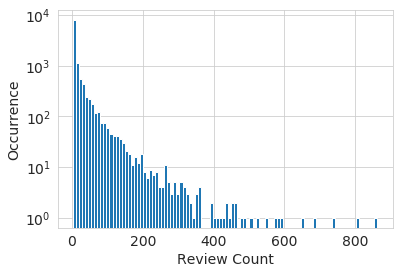

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)

### Fixed width binning

In [9]:
# Generate 20 random integers uniformly between 0 and 99
small_counts = np.random.randint(0, 100, 20)
print(small_counts)
# Map to evenly spaced bins 0-9 by division
np.floor_divide(small_counts, 10)

[26 32 19 69 25 97 50 42 45 52 59 89 12 72 26 89 52 78 70 91]


array([2, 3, 1, 6, 2, 9, 5, 4, 4, 5, 5, 8, 1, 7, 2, 8, 5, 7, 7, 9])

In [10]:
# An array of counts that span several magnitudes
large_counts = [296, 8286, 64011, 80, 3, 725, 867, 2215, 7689, 11495, 91897, 44, 28, 7971, 926, 122, 22222]

# Map to exponential-width bins via the log function
np.floor(np.log10(large_counts))

array([2., 3., 4., 1., 0., 2., 2., 3., 3., 4., 4., 1., 1., 3., 2., 2., 4.])

### Quantile binning

Fixed-width binning is easy to compute. But if there are large gaps in the counts, then there will be many empty bins with no data. This problem can be solved by adaptively positioning the bins based on the distribution of the data. This can be done using the quantiles of the distribution.
Quantiles are values that divide the data into equal portions. For example, the median divides the data in halves; half the data points are smaller and half larger than the median.

Text(0, 0.5, 'Occurrence')

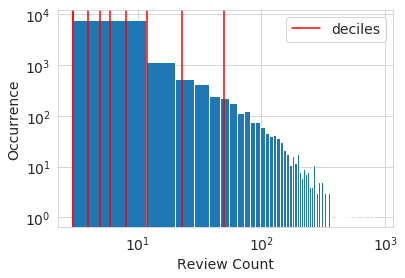

In [11]:
deciles = biz_df['review_count'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

# Visualize the deciles on the histogram
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
for pos in deciles:
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'], fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)

### Log Transformation

The log transform is a powerful tool for dealing with positive numbers with a heavy-tailed distribution. (A heavy-tailed distribution places more probability mass in the tail range than a Gaussian distribution.) It compresses the long tail in the high end of the distribution into a shorter tail, and expands the low end into a longer head.


Text(0, 0.5, 'Occurrence')

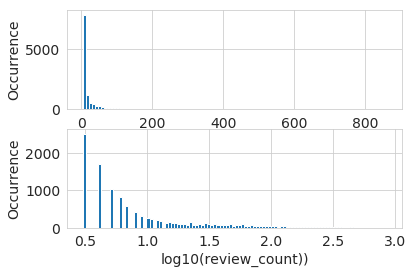

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1)
biz_df['review_count'].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('review_count', fontsize=14)
ax1.set_ylabel('Occurrence', fontsize=14)

biz_df['log_review_count'] = np.log10(biz_df['review_count'])
biz_df['log_review_count'].hist(ax=ax2, bins=100)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('log10(review_count))', fontsize=14)
ax2.set_ylabel('Occurrence', fontsize=14)

-0.5631160899391674


Text(0.5, 1.0, 'Probplot after Box-Cox transform')

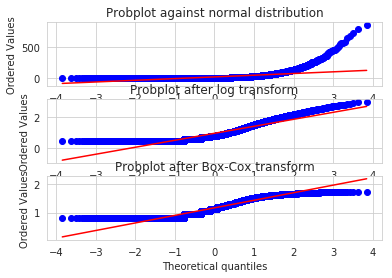

In [21]:
from scipy import stats

# By default, the scipy implementation of Box-Cox transform finds the lambda
# parameter that will make the output the closest to a normal distribution
rc_bc, bc_params = stats.boxcox(biz_df['review_count'])
print(bc_params)
# -0.5631160899391674
biz_df['rc_bc'] = stats.boxcox(biz_df['review_count'], lmbda = bc_params)

fig2, (ax1, ax2, ax3) = plt.subplots(3,1)
prob1 = stats.probplot(biz_df['review_count'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
prob2 = stats.probplot(biz_df['log_review_count'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('')
ax2.set_title('Probplot after log transform')
prob3 = stats.probplot(biz_df['rc_bc'], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_title('Probplot after Box-Cox transform')

### Power Transforms: Generalization of the Log Transform

![Fig](imgs/img_001.png)

The Box-Cox formulation only works when the data is positive. For nonpositive data, one could shift the values by adding a fixed constant. When applying the Box-Cox transformation or a more general power transform, we have to determine a value for the parameter λ. This may be done via maximum likelihood (finding the λ that maximizes the Gaussian likelihood of the resulting transformed signal) or Bayesian methods.

### Feature Interaction

In [22]:
df = pd.read_csv('../datasets/OnlineNewsPopularity/OnlineNewsPopularity.csv', delimiter=', ')

/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [23]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [25]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [24]:
features = ['n_tokens_title', 'n_tokens_content',
            'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
            'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
            'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
            'data_channel_is_entertainment', 'data_channel_is_bus',
            'data_channel_is_socmed', 'data_channel_is_tech',
            'data_channel_is_world']

In [31]:
from tqdm import tqdm_notebook
for col in tqdm_notebook(features):
    print(col, df[col].dtype, df[col].nunique())

n_tokens_title float64 20
n_tokens_content float64 2406
n_unique_tokens float64 27281
n_non_stop_words float64 1451
n_non_stop_unique_tokens float64 22930
num_hrefs float64 133
num_self_hrefs float64 59
num_imgs float64 91
num_videos float64 53
average_token_length float64 30136
num_keywords float64 10
data_channel_is_lifestyle float64 2
data_channel_is_entertainment float64 2
data_channel_is_bus float64 2
data_channel_is_socmed float64 2
data_channel_is_tech float64 2
data_channel_is_world float64 2





Generate polynomial and interaction features.

Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].


In [34]:
import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X = df[features]
y = df[['shares']]
X2 = preproc.PolynomialFeatures(include_bias=False).fit_transform(X)
X2.shape

(39644, 170)

In [43]:
??train_test_split

In [36]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X, X2, y, test_size=0.3,random_state=123)

In [37]:
y_test.shape

(11894, 1)

In [40]:
from sklearn import linear_model
def evaluate_feature(X_train, X_test, y_train, y_test):
    '''Fit a linear regression model on the training set and score on the test set'''
    model = linear_model.LinearRegression().fit(X_train, y_train)
    r_score = model.score(X_test, y_test)
    return (model, r_score)

In [41]:
(m1, r1) = evaluate_feature(X1_train, X1_test, y_train, y_test)
print("R-squared score with singleton features: %0.5f" % r1)

R-squared score with singleton features: 0.00924


In [42]:
(m2, r2) = evaluate_feature(X2_train, X2_test, y_train, y_test)
print("R-squared score with pairwise features: %0.10f" % r2)

R-squared score with pairwise features: 0.0113280016


### Feature Scaling

If your model is sensitive to the scale of input features, feature scaling could help. As the name suggests, feature scaling changes the scale of the feature. Sometimes people also call it feature normalization. Feature scaling is usually done individually to each feature.

In [45]:
# Look at the original data - the number of words in an article
print(df['n_tokens_content'].values)
# array([ 219.,  255.,  211., ...,  442.,  682.,  157.])

# Min-max scaling
df['minmax'] = preproc.minmax_scale(df[['n_tokens_content']])
print(df['minmax'].values)

[219. 255. 211. ... 442. 682. 157.]
[0.02584376 0.03009205 0.02489969 ... 0.05215955 0.08048147 0.01852726]


### Don’t “Center” Sparse Data!
Use caution when performing min-max scaling and standardization on sparse features. Both subtract a quantity from the original feature value. For min-max scaling, the shift is the minimum over all values of the current feature; for standardization, it is the mean. If the shift is not zero, then these two transforms can turn a sparse feature vector where most values are zero into a dense one. This in turn could create a huge computational burden for the classifier, depending on how it is implemented (not to mention that it would be horrendous if the representation now included every word that didn’t appear in a document!). Bag-of-words is a sparse representation, and most classification libraries optimize for sparse inputs.

In [46]:
df['standardized'] = preproc.StandardScaler().fit_transform(df[['n_tokens_content']])
print(df['standardized'].values)

# L2-normalization
df['l2_normalized'] = preproc.normalize(df[['n_tokens_content']], axis=0)
print(df['l2_normalized'].values)

[-0.69521045 -0.61879381 -0.71219192 ... -0.2218518   0.28759248
 -0.82681689]
[0.00152439 0.00177498 0.00146871 ... 0.00307663 0.0047472  0.00109283]


Feature scaling is useful in situations where a set of input features differs wildly in scale. For instance, the number of daily visitors to a popular ecommerce site might be a hundred thousand, while the actual number of sales might be in the thousands. If both of those features are thrown into a model, then the model will need to balance its scale while figuring out what to do. Drastically varying scale in input features can lead to numeric stability issues for the model training algorithm.

### Counting words

#### Bag-of-Words
In bag-of-words (BoW) featurization, a text document is converted into a vector of counts. (A vector is just a collection of n numbers.) The vector contains an entry for every possible word in the vocabulary. If the word — say, “aardvark” — appears three times in the document, then the feature vector has a count of 3 in the position corresponding to that word. If a word in the vocabulary doesn’t appear in the document, then it gets a count of 0.

In [47]:
f = open('../datasets/yelp_academic_dataset_review_my.json')
js = []
for i in range(10000):
    js.append(json.loads(f.readline()))
f.close()
review_df = pd.DataFrame(js)
review_df.shape

(10000, 9)

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
bow_converter = CountVectorizer(token_pattern='(?u)\\b\\w+\\b')
x = bow_converter.fit_transform(review_df['text'])
# print(x)
words = bow_converter.get_feature_names()
bigram_converter = CountVectorizer(ngram_range=(2,2), token_pattern='(?u)\\b\\w+\\b')
x2 = bigram_converter.fit_transform(review_df['text'])
bigrams = bigram_converter.get_feature_names()
print(len(bigrams))
trigram_converter = CountVectorizer(ngram_range=(3,3), token_pattern='(?u)\\b\\w+\\b')
x3 = trigram_converter.fit_transform(review_df['text'])
trigrams = trigram_converter.get_feature_names()
print(len(trigrams))
print(trigrams[:10])

print(len(words), len(bigrams), len(trigrams))

316034
738062
['0 1 0', '0 1 dessert', '0 1 good', '0 1 it', '0 1 prices', '0 1 speed', '0 10 mbps', '0 2 decor', '0 2 even', '0 2 it']
26290 316034 738062


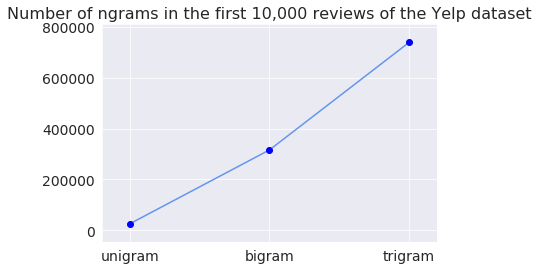

In [51]:
sns.set_style("darkgrid")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='cornflowerblue')
plt.plot(counts, 'bo')
plt.margins(0.1)
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in the first 10,000 reviews of the Yelp dataset', {'fontsize':16})
plt.show()

![Fig](imgs/img_002.png)

### Chunking and part-of-speech tagging
Chunking is a bit more sophisticated than finding n-grams, in that it forms sequences of tokens based on parts of speech, using rule-based models.
For example, we might be most interested in finding all of the noun phrases in a problem where the entity (in this case the subject of a text) is the most interesting to us. In order to find this, we tokenize each word with a part of speech and then examine the token’s neighborhood to look for part-of-speech groupings, or “chunks.” The models that map words to parts of speech are generally language specific.

In [1]:
import pandas as pd
import json


# Load the first 10 reviews
f = open('../datasets/yelp_academic_dataset_review_my.json')
js = []
for i in range(10):
    js.append(json.loads(f.readline()))
f.close()
review_df = pd.DataFrame(js)
review_df.shape



(10, 9)

In [2]:
# !pip install spacy

In [4]:
#### Using spacy
import spacy

spacy.info('en')


    Info about model en

    lang               en             
    pipeline           ['tagger', 'parser', 'ner']
    accuracy           {'token_acc': 99.8698372794, 'ents_p': 84.9664503965, 'ents_r': 85.6312524451, 'uas': 91.7237657538, 'tags_acc': 97.0403350292, 'ents_f': 85.2975560875, 'las': 89.800872413}
    name               core_web_sm    
    license            CC BY-SA 3.0   
    author             Explosion AI   
    url                https://explosion.ai
    vectors            {'keys': 0, 'width': 0, 'vectors': 0}
    sources            ['OntoNotes 5', 'Common Crawl']
    version            2.0.0          
    spacy_version      >=2.0.0a18     
    parent_package     spacy          
    speed              {'gpu': None, 'nwords': 291344, 'cpu': 5122.3040471407}
    email              contact@explosion.ai
    description        English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS 

{'lang': 'en',
 'pipeline': ['tagger', 'parser', 'ner'],
 'accuracy': {'token_acc': 99.8698372794,
  'ents_p': 84.9664503965,
  'ents_r': 85.6312524451,
  'uas': 91.7237657538,
  'tags_acc': 97.0403350292,
  'ents_f': 85.2975560875,
  'las': 89.800872413},
 'name': 'core_web_sm',
 'license': 'CC BY-SA 3.0',
 'author': 'Explosion AI',
 'url': 'https://explosion.ai',
 'vectors': {'keys': 0, 'width': 0, 'vectors': 0},
 'sources': ['OntoNotes 5', 'Common Crawl'],
 'version': '2.0.0',
 'spacy_version': '>=2.0.0a18',
 'parent_package': 'spacy',
 'speed': {'gpu': None, 'nwords': 291344, 'cpu': 5122.3040471407},
 'email': 'contact@explosion.ai',
 'description': 'English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Assigns word vectors, context-specific token vectors, POS tags, dependency parse and named entities.',
 'link': '/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/spacy/data/en',
 'source': '/home/watts/anaconda3/envs/itv/lib/python3.6/sit

In [5]:
# preload the language model
nlp = spacy.load('en')

In [6]:
# Keeping it in a pandas dataframe
doc_df = review_df['text'].apply(nlp)

type(doc_df)

pandas.core.series.Series

In [7]:
type(doc_df[0])

spacy.tokens.doc.Doc

In [8]:
doc_df[4]

Today was my second out of three sessions I had paid for. Although my first session went well, I could tell Meredith had a particular enjoyment for her male clients over her female. However, I returned because she did my teeth fine and I was pleased with the results. When I went in today, I was in the whitening room with three other gentlemen. My appointment started out well, although, being a person who is in the service industry, I always attend to my female clientele first when a couple arrives. Unbothered by those signs, I waited my turn. She checked on me once after my original 30 minute timer to ask if I was ok. She attended my boyfriend on numerous occasions, as well as the other men, and would exit the room without even asking me or looking to see if I had any irritation. Half way through, another woman had showed up who she was explaining the deals to in the lobby. While she admits timers must be reset half way through the process, she reset my boyfriends, left, rest the gentl

In [9]:
# spacy gives you both fine grained (.pos_) + coarse grained (.tag_) parts of speech    
for doc in doc_df[4]:
    print(doc.text, doc.pos_, doc.tag_)

Today NOUN NN
was VERB VBD
my ADJ PRP$
second ADJ JJ
out ADP IN
of ADP IN
three NUM CD
sessions NOUN NNS
I PRON PRP
had VERB VBD
paid VERB VBN
for ADP IN
. PUNCT .
Although ADP IN
my ADJ PRP$
first ADJ JJ
session NOUN NN
went VERB VBD
well ADV RB
, PUNCT ,
I PRON PRP
could VERB MD
tell VERB VB
Meredith PROPN NNP
had VERB VBD
a DET DT
particular ADJ JJ
enjoyment NOUN NN
for ADP IN
her ADJ PRP$
male ADJ JJ
clients NOUN NNS
over ADP IN
her ADJ PRP$
female NOUN NN
. PUNCT .
However ADV RB
, PUNCT ,
I PRON PRP
returned VERB VBD
because ADP IN
she PRON PRP
did VERB VBD
my ADJ PRP$
teeth NOUN NNS
fine ADJ JJ
and CCONJ CC
I PRON PRP
was VERB VBD
pleased ADJ JJ
with ADP IN
the DET DT
results NOUN NNS
. PUNCT .
When ADV WRB
I PRON PRP
went VERB VBD
in ADP IN
today NOUN NN
, PUNCT ,
I PRON PRP
was VERB VBD
in ADP IN
the DET DT
whitening NOUN NN
room NOUN NN
with ADP IN
three NUM CD
other ADJ JJ
gentlemen NOUN NNS
. PUNCT .
My ADJ PRP$
appointment NOUN NN
started VERB VBD
out PART RP
well ADV RB
,

In [10]:
# spaCy also does noun chunking for us

print([chunk for chunk in doc_df[4].noun_chunks])

[Today, three sessions, I, my first session, I, Meredith, a particular enjoyment, her male clients, her female, I, she, my teeth, I, the results, I, today, I, the whitening room, three other gentlemen, My appointment, a person, who, the service industry, I, my female clientele, a couple, those signs, I, my turn, She, me, my original 30 minute timer, I, She, my boyfriend, numerous occasions, the other men, the room, me, I, any irritation, another woman, who, she, the deals, the lobby, she, timers, the process, she, my boyfriends, the gentleman, me, who, time, his deal, his timer, me, this point, my time, 10 minutes, she, it, her, I, major pain, my gums, i, the time, the lamp, she, two others, deals, other guest, she, my time, my light, I, the stance, my mouth, a more relaxed state, I, a thirty minute session, she, this point, the teeth formula, the gum, she, 25 minutes, it, my lips, I, my chair, her attention, the other room, a panic, I, so much pain, the time, she, the room, I, my chai

### TF-IDF

Tf-idf is a simple twist on the bag-of-words approach. It stands for term frequency–inverse document frequency.  Instead of looking at the raw counts of each word in each document in a dataset, tf-idf looks at a normalized count where each word count is divided by the number of documents this word appears in. That is:
bow(w, d) = # times word w appears in document d
tf-idf(w, d) = bow(w, d) * N / (# documents in which word w appears)
N is the total number of documents in the dataset. The fraction N / (# documents ...) is what’s known as the inverse document frequency. If a word appears in many documents, then its inverse document frequency is close to 1. If a word appears in just a few documents, then the inverse document frequency is much higher.

In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as modsel
import sklearn.preprocessing as preproc

In [2]:
## Load Yelp Business data
biz_f = open('../datasets/yelp_academic_dataset_business_my.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])
biz_f.close()

## Load Yelp Reviews data
review_file = open('../datasets/yelp_academic_dataset_review_my.json')
review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])
review_file.close()

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/yelp_academic_dataset_business_my.json'

In [62]:
review_df.shape

(15000, 9)

In [63]:
review_df.head(1)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1.0,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA


In [64]:
biz_df.shape

(192609, 14)

In [65]:
biz_df.head(1)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ


In [68]:
biz_df['categories'].isnull().sum()

482

In [70]:
biz_df.iloc[265]

address               6340 E Thomas Rd
attributes                        None
business_id     xOR85RicYj642O3_iJ7hgg
categories                        None
city                        Scottsdale
hours                             None
is_open                              1
latitude                       33.4804
longitude                     -111.946
name                Phoenix Valuations
postal_code                      85251
review_count                         3
stars                              3.5
state                               AZ
Name: 265, dtype: object

In [75]:
biz_df['categories'] = biz_df['categories'].map(lambda x: x if x is not None else 'None')

In [76]:
# Pull out only Nightlife and Restaurants businesses
two_biz = biz_df[biz_df.apply(lambda x: 'Nightlife' in x['categories'].split(',') or 
                              'Restaurants' in x['categories'].split(','), axis=1)]

In [77]:
two_biz.shape

(20661, 14)

In [78]:
## Join with the reviews to get all reviews on the two types of business
twobiz_reviews = two_biz.merge(review_df, on='business_id', how='inner')

In [79]:
twobiz_reviews.shape

(2858, 22)

In [80]:
twobiz_reviews.to_pickle('../cache/twobiz_reviews.pkl')

In [81]:
twobiz_reviews = pd.read_pickle('../cache/twobiz_reviews.pkl')

In [82]:
# Trim away the features we won't use
twobiz_reviews = twobiz_reviews[['business_id', 
                                 'name', 
                                 'stars_y', 
                                 'text', 
                                 'categories']]

In [83]:
twobiz_reviews.head()

,business_id,name,stars_y,text,categories
0,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,5.0,"We went there for dinner the other night, bein...","Restaurants, Italian"
1,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,4.0,i had the best Chicken Marcela ever. The spagh...,"Restaurants, Italian"
2,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,5.0,It's awesome here!!The guys are soooo hot and ...,"Nightlife, Arts & Entertainment, Bars, Strip C..."
3,KWywu2tTEPWmR9JnBc0WyQ,Hunk Mansion,5.0,I came to Hunk Mansion April 11th 2014 for my ...,"Nightlife, Arts & Entertainment, Bars, Strip C..."
4,dQj5DLZjeDK3KFysh1SYOQ,Apteka,5.0,It doesn't get more kooky than meatless easter...,"Nightlife, Bars, Polish, Modern European, Rest..."


In [84]:
# Create the target column--True for Nightlife businesses, and False otherwise
twobiz_reviews['target'] = twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'],axis=1)

In [85]:
## Now pull out each class of reviews separately, 
## so we can create class-balanced samples for training
nightlife = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Nightlife' in x['categories'], axis=1)]
restaurants = twobiz_reviews[twobiz_reviews.apply(lambda x: 'Restaurants' in x['categories'], axis=1)]

In [86]:
nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurant_subset = restaurants.sample(frac=0.021, random_state=123)

In [87]:
nightlife_subset.to_pickle('../cache/nightlife_subset.pkl')
restaurant_subset.to_pickle('../cache/restaurant_subset.pkl')

In [88]:
nightlife_subset = pd.read_pickle('../cache/nightlife_subset.pkl')
restaurant_subset = pd.read_pickle('../cache/restaurant_subset.pkl')

In [89]:
combined = pd.concat([nightlife_subset, restaurant_subset])

In [90]:
combined.shape

(137, 6)

In [91]:
combined

,business_id,name,stars_y,text,categories,target
1220,fu8ZdJMcX6GSVf3BbWOsgg,Fuego Cantina,4.0,"I want to give 5 to help out the Yelp score, ...","Nightlife, Diners, Sports Bars, Restaurants, B...",True
621,ZCsvwa_dsqNB8d8tYHPdjw,Sir Edmond Halley's,4.0,This random hole in the wall is located in the...,"Restaurants, Pubs, Bars, Fish & Chips, Nightlife",True
1581,SVGApDPNdpFlEjwRQThCxA,Juan's Flaming Fajitas & Cantina,5.0,Every time I come back to visit vegas Juans is...,"Nightlife, Restaurants, Bars, Mexican",True
2393,4hG2j_ibsNblDgqei05U_g,Social House,2.0,We knew we wanted ramen while in Vegas (hot so...,"Restaurants, Lounges, Sushi Bars, Japanese, Ni...",True
712,-RC3XAvgvb-vwS3JtYPRHg,Hà,4.0,Amazing little joint with great service. Go f...,"Nightlife, Restaurants, Bars, Asian Fusion, Vi...",True
1693,guFIqSvxlwQnFfe301wg3A,Duggan's Brewery,4.0,Had a nice date here with the bae on Friday ni...,"Nightlife, Breweries, Food, Pubs, Bars, Canadi...",True
2102,8zN3nV0zbtE377_XhlvabA,Jolie's Place,5.0,Excellent service at the bar and when I ordere...,"Restaurants, Bars, Sports Bars, Karaoke, Night...",True
1179,bjzFOyHG4Ux1CPCIk-b_5A,NoDa 101,3.0,Stopped in here with some coworkers for a coup...,"Restaurants, American (Traditional), Nightlife...",True
1786,H8qlBw1YaxMsItfz25-AyA,John Cutter,1.0,"UPDATE: sent an email to Kristy Morrison, Gen...","Nightlife, American (New), Burgers, Bars, Rest...",True
1310,qTmuW0C9XXuxWwumvn89sw,The Mac King Comedy Magic Show,5.0,It was a very funny and entertaining family fr...,"Nightlife, Comedy Clubs, Adult Entertainment, ...",True


In [92]:
combined['target'] = combined.apply(lambda x: 'Nightlife' in x['categories'],axis=1)

In [93]:
# Split into training and test data sets
training_data, test_data = modsel.train_test_split(combined, train_size=0.7, random_state=123)

/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [94]:
# Represent the review text as a bag-of-words 
bow_transform = text.CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])

In [95]:
X_te_bow = bow_transform.transform(test_data['text'])

In [96]:
y_tr = training_data['target']
y_te = test_data['target']

In [97]:
# Create the tf-idf representation using the bag-of-words matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)

In [98]:
X_te_tfidf = tfidf_trfm.transform(X_te_bow)


In [99]:
X_tr_l2 = preproc.normalize(X_tr_bow, axis=0)
X_te_l2 = preproc.normalize(X_te_bow, axis=0)

In [100]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression(C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

In [101]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.5476190476190477
Test score with l2-normalized features: 0.6190476190476191
Test score with tf-idf features: 0.6904761904761905


/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [102]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = modsel.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
l2_search = modsel.GridSearchCV(LogisticRegression(), cv=5,
                               param_grid=param_grid_)
tfidf_search = modsel.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [103]:
bow_search.fit(X_tr_bow, y_tr)


/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [104]:
bow_search.best_score_

0.6421052631578947

In [105]:
l2_search.fit(X_tr_l2, y_tr)

/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
l2_search.best_score_


0.6421052631578947

In [107]:
tfidf_search.fit(X_tr_tfidf, y_tr)


/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [108]:
tfidf_search.best_score_


0.6526315789473685

In [111]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score'],
                               'l2': l2_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf,l2
0,0.642105,0.642105,0.642105
1,0.642105,0.642105,0.642105
2,0.589474,0.642105,0.642105
3,0.610526,0.642105,0.642105
4,0.600000,0.652632,0.631579
5,0.610526,0.631579,0.642105


In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

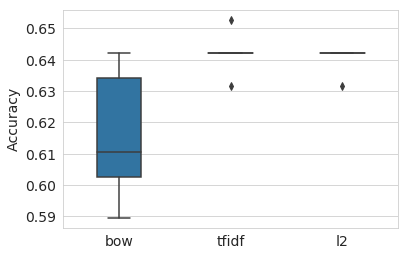

In [112]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

In [113]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized', 
                              _C=l2_search.best_params_['C'])
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test score with bow features: 0.6666666666666666
Test score with l2-normalized features: 0.6666666666666666
Test score with tf-idf features: 0.6428571428571429


/home/watts/anaconda3/envs/itv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
